# [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data?select=sales_train.csv)




## Library

In [199]:
# data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm # for loop bar
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# translator
from googletrans import Translator
# transformation
from itertools import product
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras import optimizers
from xgboost import XGBRegressor
from xgboost import plot_importance

## Description
- 과거의 판매 데이터. test 데이터를 이용하여 shop별로 특정아이템이 얼마나 팔릴지 예측. 매달 팔리는 양이 가게마다 제품마다 다름. 따라서 이를 수용하는 모델을 만들어야 함.
<br>

- Y = 특정 shop에 item_id 별로 팔리는 item_cnt_month   
=> 일별로 예측 후 합산 하거나 (2)   
=> 월별로 환산해서 나중에 합치는 방법 존재. (1)
<br>

- ID: an Id that represents a (Shop, Item) tuple within the test set
- shop_id: unique identifier of a shop **(60개)**
- item_id: unique identifier of a product **(22170개)**
- item_category_id: unique identifier of item category **(84개 카테고리)**
- item_cnt_day: number of products sold. You are predicting a monthly amount of this measure **(Y값)**
- item_price: current price of an item 
- date: date in format dd/mm/yyyy
- date_block_num: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name: name of item 
- shop_name: name of shop 
- item_category_name: name of item category

## Data Loading

In [2]:
item_cat = pd.read_csv('../../data/item_cat_en.csv')
items = pd.read_csv('../../data/item_en.csv')
sales_train = pd.read_csv('../../data/sales_train.csv')
shops = pd.read_csv('../../data/shops.csv')

In [3]:
test = pd.read_csv('../../data/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
print(item_cat.head())
print(items.head())
print(sales_train.head())
print(shops.head())
print(test.head())

   Unnamed: 0       item_category_name  item_category_id  \
0           0  PC - Гарнитуры/Наушники                 0   
1           1         Аксессуары - PS2                 1   
2           2         Аксессуары - PS3                 2   
3           3         Аксессуары - PS4                 3   
4           4         Аксессуары - PSP                 4   

        item_category_name_en  
0  PC - Headsets / Headphones  
1           Accessories - PS2  
2           Accessories - PS3  
3           Accessories - PS4  
4           Accessories - PSP  
   Unnamed: 0                                          item_name  item_id  \
0           0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1           1  !ABBYY FineReader 12 Professional Edition Full...        1   
2           2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3           3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4           4        ***КОРОБКА (СТЕКЛО)                      

## Russian -> English
- 데이터 해석을 쉽게 할 수 있도록 번역

In [5]:
# translator = Translator()

In [6]:
# # item_category_id
# item_cat['item_category_name_en'] = 'a'
# for i in range(len(item_cat)):
#     item_cat['item_category_name_en'][i] = translator.translate(item_cat['item_category_name'][i],src='ru',dest='en').text

In [7]:
# # item_category_id
# #items['item_name_en'] = items['item_name'].apply(lambda x: translator.translate(x, src='ru', dest='en').text )
# items['item_name_en'] = 'a'
# for i in range(5000):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text
# for i in range(5000,10000):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text
# for i in range(10000,15000):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text
# for i in range(15000,22171):
#     items['item_name_en'][i] = translator.translate(items['item_name'][i],src='ru',dest='en').text

In [8]:
# 매번 번역 과정을 거치면 시간이 오래걸리므로.. 번역한 것 저장해서 사용.
# item_cat.to_csv('data/item_cat_en.csv')
# items.to_csv('data/item_en.csv')

## Data Exploration
### Data Check
#### NULL 값 확인 
- 없음 ^^

In [9]:
print(item_cat.isna().sum())
print(items.isna().sum())
print(sales_train.isna().sum())
print(shops.isna().sum())

Unnamed: 0               0
item_category_name       0
item_category_id         0
item_category_name_en    0
dtype: int64
Unnamed: 0          0
item_name           0
item_id             0
item_category_id    0
item_name_en        0
dtype: int64
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
shop_name    0
shop_id      0
dtype: int64


- summary 확인
- item_price, item_cnt_day에 마이너스값 존재 => 이유 확인 필요

In [10]:
summary = sales_train.describe().round(3)
summary

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.000,2935849.000,2935849.000,2935849.000,2935849.000
mean,14.570,33.002,10197.227,890.853,1.243
std,9.423,16.227,6324.297,1729.800,2.619
min,0.000,0.000,0.000,-1.000,-22.000
25%,7.000,22.000,4476.000,249.000,1.000
50%,14.000,31.000,9343.000,399.000,1.000
75%,23.000,47.000,15684.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


#### item_cnt_day 확인
- item_cnt_day의 minus 값 확인 (7356개)
- 1) 환불 되었을 가능성 => 대충 확인이 가능함. 동일한 가격, shop, item 목록이 몇일 내에 존재한다면 확불로 추측. (논의 필요.)
- 2) 도난 되었을 가능성 => 확인할 방법이 없고 그냥 삭제
- 3) 오류일 가능성

In [11]:
sales_minus = sales_train[sales_train.item_cnt_day<0]
sales_minus

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


- 아래는 환불되었는지 확인하는 과정:    
환불을 받았으면 구매한 내역도 있을 것이라 추론.   
즉, shop_id와 item_id로 조회했을 때 기록이 2개 이상 나와야함.   
1개만 나오는 경우, 해당 데이터 이전에 구매했기 때문일 수도 있으므로 data_block_num이 모두 0이 되어야 함.   
<br>

- 하지만 확인 결과, 기록이 1개인 것이 25개가 존재하며, 이 중 data_block_num이 0이 아닌 것이 몇개 존재함.
- 따라서 그냥 삭제 처리함.

In [12]:
# check => 같은 shop_id, item_id값이 1개만 존재
# dictionary로 shop_id, item_id mapping
minus_l = []
minus = zip(sales_minus['shop_id'], sales_minus['item_id'])
minus = list(set(minus))
# unique shop_id, item_id
print(len(minus))
for i in range(len(minus)):
    minus_l.append(len(sales_train.loc[(sales_train['shop_id']==minus[i][0]) & (sales_train['item_id']==minus[i][1])]))
# 최소값 
min(minus_l)
#len(sales_train.loc[(sales_train['shop_id']==25) & (sales_train['item_id']==2552)])

6806


1

In [13]:
minus_l.count(1) # 25개 존재.

25

In [14]:
# 이전 날짜가 데이터에 없어서 잘린 걸수도 있으므로 date_block_num확인
# 모두 0이면 환불 데이터로 취급
# 쌩뚱맞은 것들이 있음. -> 그냥 마이너스는 다 삭제
minus_idx = [i for i, e in enumerate(minus_l) if e == 1]
minus_df = pd.DataFrame()
for i in minus_idx:
    minus_df = pd.concat([minus_df,sales_train.loc[(sales_train['shop_id']==minus[i][0]) & (sales_train['item_id']==minus[i][1]),['date_block_num','shop_id','item_id']]])
minus_df[minus_df.date_block_num!=0]

,date_block_num,shop_id,item_id
744566,7,42,13474
142796,1,16,18062
194977,1,41,6664
176750,1,12,15435
549457,5,46,13473
186255,1,32,6664
798185,7,16,13477
2859389,32,22,9255


In [15]:
# 마이너스값 삭제
sales_train = sales_train[sales_train.item_cnt_day>=0]

#### item_price 이상치 확인
- 어짜피 한 개 이므로 삭제

In [16]:
item_p_minus = sales_train[sales_train.item_price<=0]
item_p_minus

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [17]:
sales_train = sales_train[sales_train.item_price>0]

In [18]:
# Describe 다시 확인
# item 최소 1개부터 2169개까지 팔림
summary = sales_train.describe().round(3)
summary

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2928492.000,2928492.000,2928492.000,2928492.000,2928492.000
mean,14.570,33.003,10200.282,889.467,1.248
std,9.423,16.225,6324.396,1727.499,2.620
min,0.000,0.000,0.000,0.070,1.000
25%,7.000,22.000,4477.000,249.000,1.000
50%,14.000,31.000,9355.000,399.000,1.000
75%,23.000,47.000,15691.000,999.000,1.000
max,33.000,59.000,22169.000,307980.000,2169.000


### Data Manipulation & Visualization
#### Correlation (Variable Selection)
- price 변수 사용해야 할지 결정:(삭제)    
price와 하루에 팔리는 갯수 관련 없어 보임(coefficient 매우 낮음)

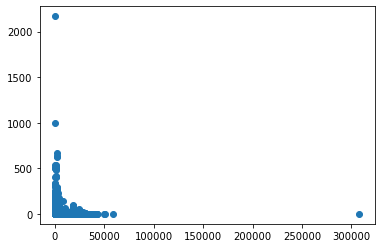

Pearsons correlation: 0.012


In [19]:
# price와 item_cnt_day와 관련이 있는지
plt.scatter(sales_train['item_price'], sales_train['item_cnt_day'])
plt.show()

from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(sales_train['item_price'], sales_train['item_cnt_day'])
print('Pearsons correlation: %.3f' % corr)

#### month로 환산

In [20]:
sales_month = sales_train.groupby(['date_block_num','shop_id','item_id'], as_index=False)['item_cnt_day'].agg('sum')
# colname 변경
sales_month = sales_month.rename(columns = {"item_cnt_day":"item_cnt_month"}) 
sales_month

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1608221,33,59,22087,6.0
1608222,33,59,22088,2.0
1608223,33,59,22091,1.0
1608224,33,59,22100,1.0


In [21]:
# sales_month에 item_category_en, item_en 붙이기
sales_month=sales_month.merge(items[['item_id','item_name_en','item_category_id']],
                 on = 'item_id',
                 how = 'left')

sales_month=sales_month.merge(item_cat[['item_category_id','item_category_name_en']], 
                  on = 'item_category_id',
                 how = 'left')

sales_month

,date_block_num,shop_id,item_id,item_cnt_month,item_name_en,item_category_id,item_category_name_en
0,0,0,32,6.0,1 + 1,40,Movie - DVD
1,0,0,33,3.0,1 + 1 (BD),37,Cinema - Blu-Ray
2,0,0,35,1.0,10 YEARS LATER,40,Movie - DVD
3,0,0,43,1.0,100 MILLION EUROS,40,Movie - DVD
4,0,0,51,2.0,Top 100 Classics (mp3-CD) (Digipack),57,Music - MP3
...,...,...,...,...,...,...,...
1608221,33,59,22087,6.0,Battery DURACELL LR03-BC2,83,Batteries
1608222,33,59,22088,2.0,Элемент питания DURACELL LR06-BC2,83,Batteries
1608223,33,59,22091,1.0,Battery DURACELL TURBO LR 03 2 * BL,83,Batteries
1608224,33,59,22100,1.0,Adventure Time Encyclopedia,42,"Books - Artbooks, encyclopedias"


#### Category 두 개로 나누기
- 23개의 카테고리로 간단하게 됨.(PC Games, Games, Movie, Music, Cinema가 많은 편)

In [98]:
sales_month=sales_month.join(sales_month['item_category_name_en'].str.split(' - ', 1, expand=True).rename(columns={0:'cat1', 1:'cat2'}))
item_cat=item_cat.join(item_cat['item_category_name_en'].str.split(' - ', 1, expand=True).rename(columns={0:'cat1', 1:'cat2'}))
items=items.merge(item_cat[['item_category_id','cat1']],on = 'item_category_id',how = 'left')
sales_month

,date_block_num,shop_id,item_id,item_cnt_month,item_name_en,item_category_id,item_category_name_en,cat1,cat2,shop_city
3921,0,2,33,1.0,1 + 1 (BD),37,Cinema - Blu-Ray,Cinema,Blu-Ray,адыгея
3926,0,2,482,1.0,1С:Бухгалтерия 8. Базовая версия,73,Programs - 1C: Enterprise 8,Programs,1C: Enterprise 8,адыгея
3928,0,2,491,1.0,1С:Деньги 8,73,Programs - 1C: Enterprise 8,Programs,1C: Enterprise 8,адыгея
3939,0,2,839,1.0,1C: Simplified 8,73,Programs - 1C: Enterprise 8,Programs,1C: Enterprise 8,адыгея
3947,0,2,1007,3.0,3D Crystal Puzzle Замок XL,67,Gifts - Development,Gifts,Development,адыгея
...,...,...,...,...,...,...,...,...,...,...
1608221,33,59,22087,6.0,Battery DURACELL LR03-BC2,83,Batteries,Batteries,None,ярославль
1608222,33,59,22088,2.0,Элемент питания DURACELL LR06-BC2,83,Batteries,Batteries,None,ярославль
1608223,33,59,22091,1.0,Battery DURACELL TURBO LR 03 2 * BL,83,Batteries,Batteries,None,ярославль
1608224,33,59,22100,1.0,Adventure Time Encyclopedia,42,"Books - Artbooks, encyclopedias",Books,"Artbooks, encyclopedias",ярославль


In [23]:
sales_month['cat1'].unique()

array(['Movie', 'Cinema', 'Music', 'Books', 'Programs', 'PC Games',
       'Gifts', 'Games', 'Accessories', 'Game consoles', 'Payment cards',
       'Blank media (spire)', 'Blank media (piece)', 'Batteries',
       'Service', 'Delivery of goods', 'PC',
       'Payment cards (Cinema, Music, Games)', 'Game Consoles',
       'Tickets (Number)', 'MAC Games', 'Android Games', 'Payment Cards'],
      dtype=object)

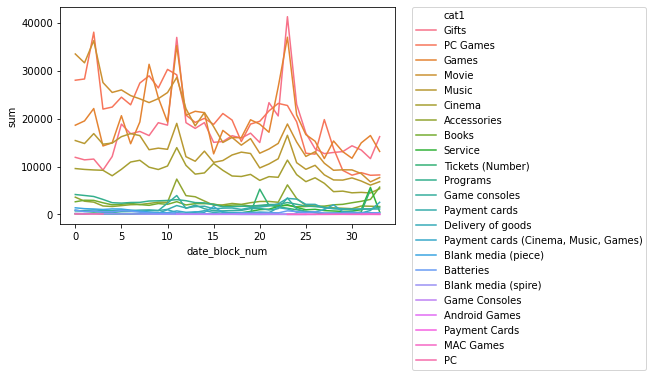

In [24]:
# category별 팔린 아이템 총 갯수
sales_cat1_check = sales_month.groupby(['date_block_num','cat1'])['item_cnt_month'].agg('sum')\
            .reset_index(name='sum').sort_values(['sum'], ascending=False)

sns.lineplot(x="date_block_num",y="sum",hue="cat1",
            units="cat1",data=sales_cat1_check, estimator=None)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

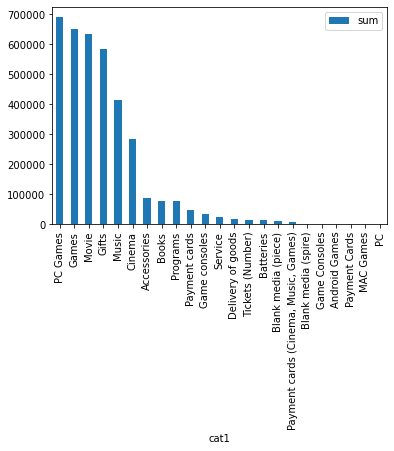

In [25]:
# 통틀어서 가장 많이 팔린 카테고리 확인 (상위 10개)
sales_month.groupby(['cat1'])['item_cnt_month']\
            .agg('sum')\
            .reset_index(name='sum')\
            .sort_values(['sum'], ascending=False)\
            .plot.bar(x='cat1',y='sum')

plt.show()

#### Shop name city와 분리
- city가 팔린 아이템 갯수에 중요한 역할 할수도 있음

In [26]:
# https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


In [27]:
sales_month=sales_month.merge(shops[['shop_id','shop_city']],
                 on = 'shop_id',
                 how = 'left')
sales_month

,date_block_num,shop_id,item_id,item_cnt_month,item_name_en,item_category_id,item_category_name_en,cat1,cat2,shop_city
0,0,0,32,6.0,1 + 1,40,Movie - DVD,Movie,DVD,якутск
1,0,0,33,3.0,1 + 1 (BD),37,Cinema - Blu-Ray,Cinema,Blu-Ray,якутск
2,0,0,35,1.0,10 YEARS LATER,40,Movie - DVD,Movie,DVD,якутск
3,0,0,43,1.0,100 MILLION EUROS,40,Movie - DVD,Movie,DVD,якутск
4,0,0,51,2.0,Top 100 Classics (mp3-CD) (Digipack),57,Music - MP3,Music,MP3,якутск
...,...,...,...,...,...,...,...,...,...,...
1608221,33,59,22087,6.0,Battery DURACELL LR03-BC2,83,Batteries,Batteries,None,ярославль
1608222,33,59,22088,2.0,Элемент питания DURACELL LR06-BC2,83,Batteries,Batteries,None,ярославль
1608223,33,59,22091,1.0,Battery DURACELL TURBO LR 03 2 * BL,83,Batteries,Batteries,None,ярославль
1608224,33,59,22100,1.0,Adventure Time Encyclopedia,42,"Books - Artbooks, encyclopedias",Books,"Artbooks, encyclopedias",ярославль


In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('item_cnt_month ~ shop_city', data=sales_month).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
shop_city,3.971764e+05,30.0,177.39108,0.0
Residual,1.200243e+08,1608195.0,NaN,NaN


In [29]:
model = ols('item_cnt_month ~ cat1', data=sales_month).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
cat1,3.426374e+06,22.0,2140.845531,0.0
Residual,1.169951e+08,1608203.0,NaN,NaN


- 매출이 좋은 가게 확인

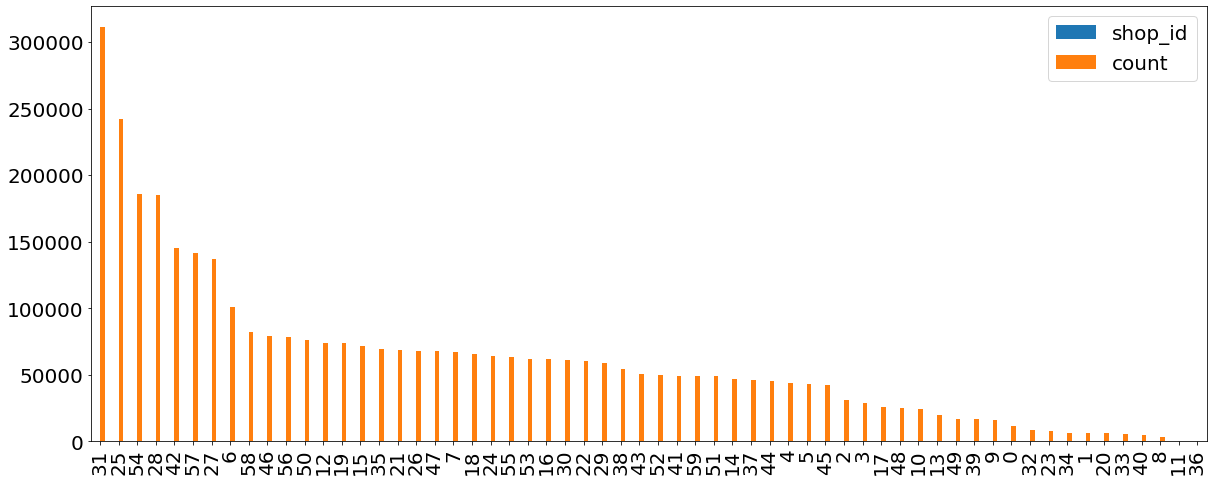

In [30]:
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['font.size'] = 20
sales_month.groupby(['shop_id'])['item_cnt_month'].sum().reset_index(name='count').sort_values(['count'], ascending=False).plot(kind='bar')
plt.show()

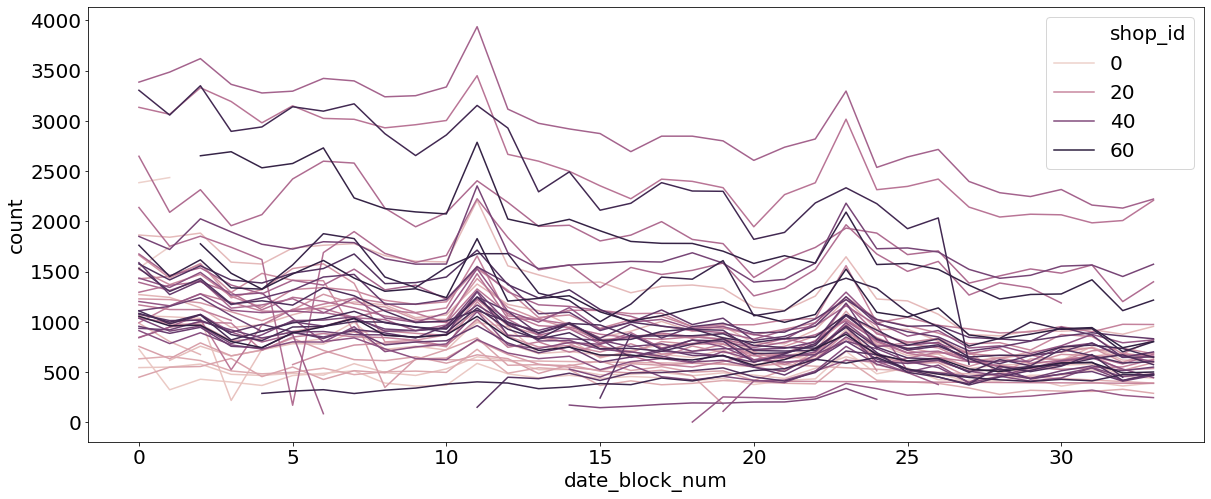

In [31]:
# 가게들 추세 확인 -> 어떤 가게는 계속 잘팔리고 어떤 가게는 계속 잘 안팔리는 경향?
# 대충 보면 추세는 얼추 비슷하게 가는 편. (어쩌다가 갑자기 하락하는 경우도 있긴 함)
sales_shop_check = sales_month.groupby(['date_block_num','shop_id'])['item_id']\
            .count()\
            .reset_index(name='count')

sns.lineplot(x="date_block_num",y="count",hue="shop_id",
            units="shop_id",data=sales_shop_check, estimator=None)

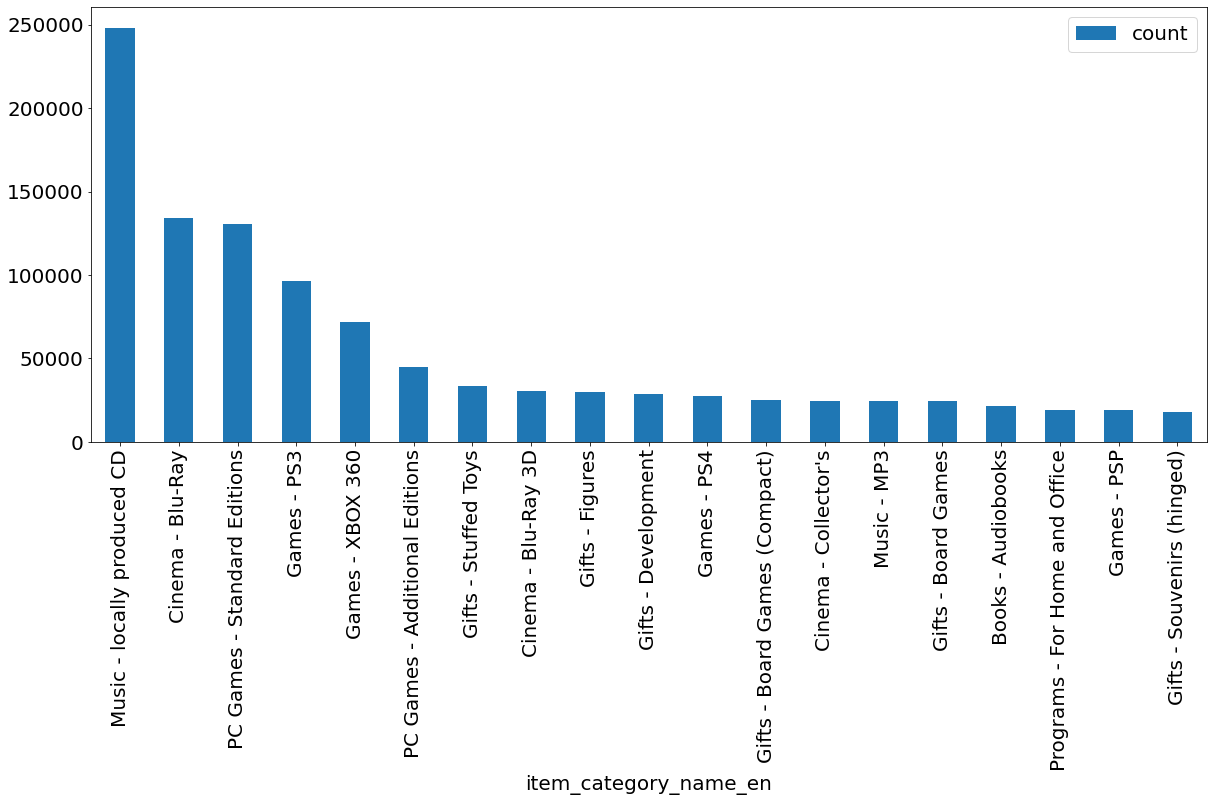

In [32]:
# 통틀어서 가장 많이 팔린 카테고리 확인 (상위 10개)
sales_month.groupby(['item_category_name_en'])['item_name_en']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]\
            .plot.bar(x='item_category_name_en',y='count')
#.plot(kind='bar')
plt.show()

In [33]:
# 상위 20개의 추세 알아보기
top20_item = sales_month.groupby(['item_category_name_en'])['item_name_en']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]['item_category_name_en']

In [34]:
item_series = sales_month.groupby(['date_block_num','item_category_name_en'])['item_name_en']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)
top20_item = item_series[item_series['item_category_name_en'].isin(top20_item)]

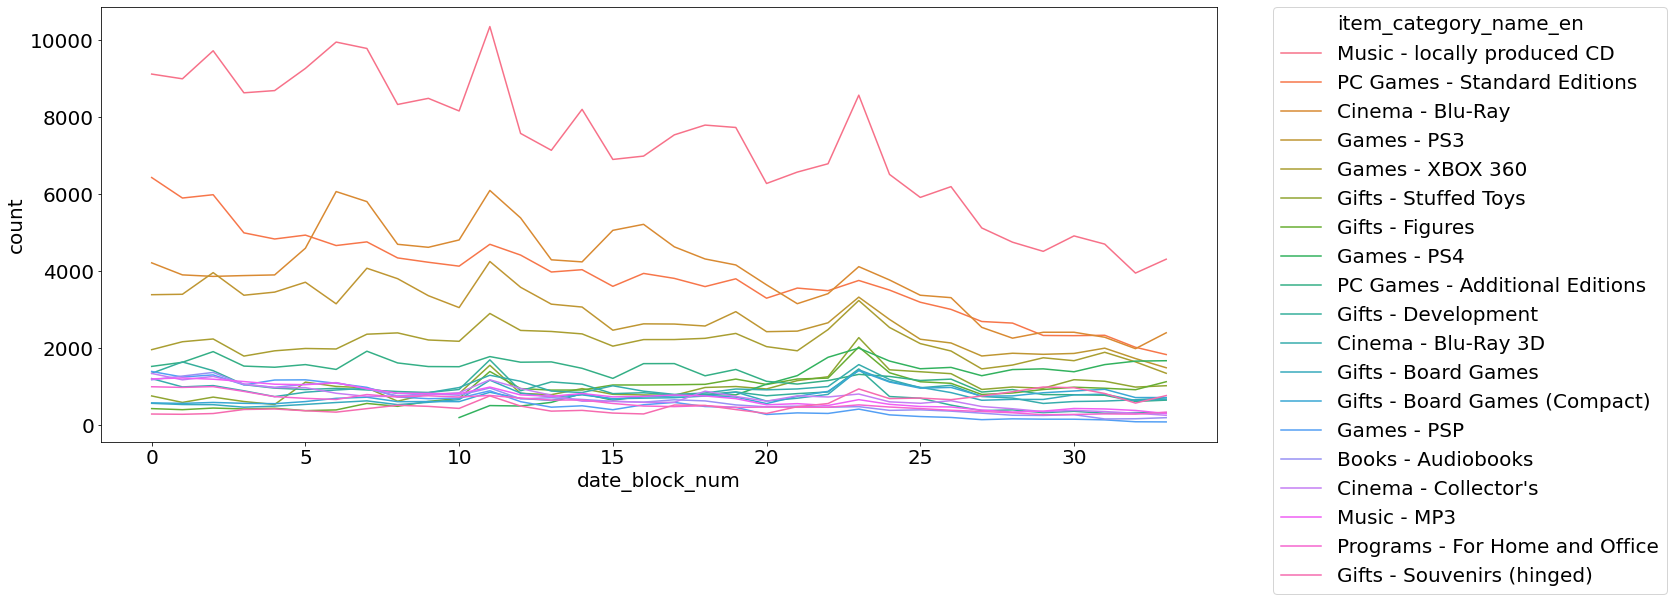

In [35]:
# 잘 팔리는 것들은 계속 잘 팔리는 듯.
sns.lineplot(x="date_block_num",y="count",hue="item_category_name_en",
            units="item_category_name_en",data=top20_item, estimator=None)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [36]:
# 가게와 많이 팔린 상품 확인 (상위 10개)
sales_month.groupby(['shop_id','cat2'])['item_name_en'] \
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]

,shop_id,cat2,count
996,25,DVD,18749
2191,54,DVD,17696
2287,57,DVD,17533
1287,31,locally produced CD,16653
2243,56,DVD,13486
1130,28,DVD,13342
1025,25,locally produced CD,12735
2328,58,DVD,11779
1158,28,locally produced CD,11310
1683,42,DVD,11242


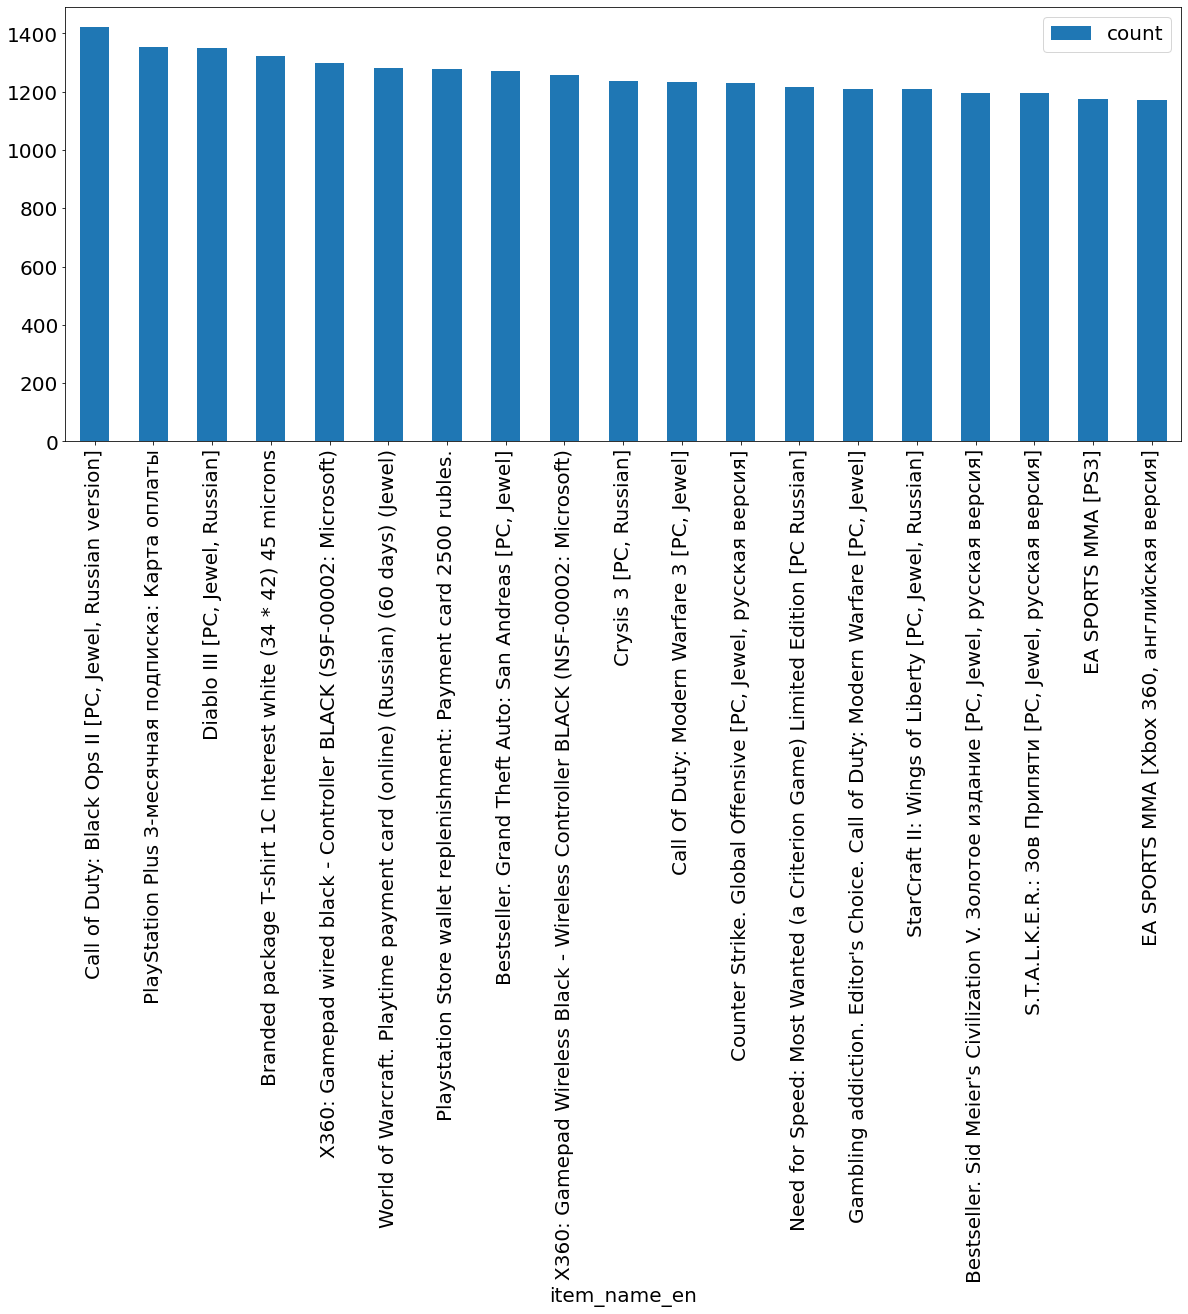

In [37]:
# 통틀어서 가장 많이 팔린 아이템 확인 (상위 20개)
# 거의 게임
sales_month.groupby(['item_name_en'])['item_id']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]\
            .plot.bar(x='item_name_en',y='count')

plt.show()

In [38]:
# 가게별로 많이 팔린 아이템 확인 (상위 20개)
sales_month.groupby(['shop_id','item_name_en'])['item_id']\
            .count()\
            .reset_index(name='count')\
            .sort_values(['count'], ascending=False)[1:20]

,shop_id,item_name_en,count
37639,6,Playstation Store wallet replenishment: Paymen...,34
62313,12,Delivery (in Moscow),34
229735,31,КЛАССИКА Маленькие шедевры великих композитор...,34
227023,31,Soft toy SOYUZMULTFILM Donkey Eeyore,34
318140,46,X360: Gamepad wired black - Controller BLACK (...,34
132569,22,1С:Деньги 8,34
45812,7,Kinect Rush [Kinect only] [Xbox 360],34
108286,18,PlayStation Plus 3-месячная подписка: Карта оп...,34
154349,25,"Call of Duty: Black Ops II [PС, Jewel, Russian...",34
62315,12,Delivery to the point of issue (Boxberry),34


#### 필요없는 아이템 삭제

In [42]:
test_shop_id = test.shop_id.unique()
test_item_id = test.item_id.unique()

In [54]:
sales_month=sales_month[sales_month.shop_id.isin(test_shop_id)]
sales_month=sales_month[sales_month.item_id.isin(test_item_id)]

#### Variable 변형 
- 각 store에서 팔리지 않은 것들 0으로 넣어줌

In [143]:
# Month, Shop ID, 제품 묶어주는 작업
matrix = []
cols = ['date_block_num','shop_id','item_id']
# 34 Month
for i in tqdm(range(34)):
    sales = sales_month[sales_month.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

100%|██████████| 34/34 [00:01<00:00, 29.12it/s]


In [144]:
matrix = pd.merge(matrix, sales_month, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
matrix = matrix.iloc[:,0:4]

#### Test data set time set
- Train set에서 0~33M까지 제시했으므로 test data set에 34 설정

In [84]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [145]:
# matrix와 합치기
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,2,32,0.0,0.0
1,0,2,33,1.0,0.0
2,0,2,42,0.0,0.0
3,0,2,45,0.0,0.0
4,0,2,51,0.0,0.0
...,...,...,...,...,...
2945733,34,45,18454,0.0,214195.0
2945734,34,45,16188,0.0,214196.0
2945735,34,45,15757,0.0,214197.0
2945736,34,45,19648,0.0,214198.0


In [146]:
# 문자열 인코딩
shops['city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
items['cat1_code'] = LabelEncoder().fit_transform(items['cat1'])
# merge matrix와 사용할 다른 변수들
matrix=matrix.merge(items[['item_id','cat1_code']],on = 'item_id',how = 'left')
matrix=matrix.merge(shops[['shop_id','city_code']],on = 'shop_id',how = 'left')

# data format 변형
matrix['cat1_code'] = matrix['cat1_code'].astype(np.int8)
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,cat1_code,city_code
0,0,2,32,0.0,0.0,13,0
1,0,2,33,1.0,0.0,6,0
2,0,2,42,0.0,0.0,14,0
3,0,2,45,0.0,0.0,14,0
4,0,2,51,0.0,0.0,14,0
...,...,...,...,...,...,...,...
2945733,34,45,18454,0.0,214195.0,14,19
2945734,34,45,16188,0.0,214196.0,11,19
2945735,34,45,15757,0.0,214197.0,14,19
2945736,34,45,19648,0.0,214198.0,13,19


#### Lag 처리

In [117]:
# lag function
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [147]:
matrix = lag_feature(matrix, [1,3,6,9,12], 'item_cnt_month')
matrix

100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


,date_block_num,shop_id,item_id,item_cnt_month,ID,cat1_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12
0,0,2,32,0.0,0.0,13,0,NaN,NaN,NaN,NaN,NaN
1,0,2,33,1.0,0.0,6,0,NaN,NaN,NaN,NaN,NaN
2,0,2,42,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN
3,0,2,45,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN
4,0,2,51,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2945733,34,45,18454,0.0,214195.0,14,19,1.0,0.0,0.0,1.0,NaN
2945734,34,45,16188,0.0,214196.0,11,19,0.0,NaN,NaN,NaN,NaN
2945735,34,45,15757,0.0,214197.0,14,19,0.0,0.0,0.0,1.0,0.0
2945736,34,45,19648,0.0,214198.0,13,19,0.0,0.0,0.0,0.0,NaN


In [148]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
matrix

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


,date_block_num,shop_id,item_id,item_cnt_month,ID,cat1_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,date_avg_item_cnt_lag_1
0,0,2,32,0.0,0.0,13,0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,1.0,0.0,6,0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,42,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,45,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,51,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945733,34,45,18454,0.0,214195.0,14,19,1.0,0.0,0.0,1.0,NaN,0.330322
2945734,34,45,16188,0.0,214196.0,11,19,0.0,NaN,NaN,NaN,NaN,0.330322
2945735,34,45,15757,0.0,214197.0,14,19,0.0,0.0,0.0,1.0,0.0,0.330322
2945736,34,45,19648,0.0,214198.0,13,19,0.0,0.0,0.0,0.0,NaN,0.330322


In [149]:
# month, item별로 mean
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,9,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
matrix

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


,date_block_num,shop_id,item_id,item_cnt_month,ID,cat1_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_9,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_9,date_item_avg_item_cnt_lag_12
0,0,2,32,0.0,0.0,13,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,1.0,0.0,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,42,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,45,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,51,0.0,0.0,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945733,34,45,18454,0.0,214195.0,14,19,1.0,0.0,0.0,1.0,NaN,0.330322,0.047607,0.073181,0.585449,2.150391,NaN
2945734,34,45,16188,0.0,214196.0,11,19,0.0,NaN,NaN,NaN,NaN,0.330322,0.023804,NaN,NaN,NaN,NaN
2945735,34,45,15757,0.0,214197.0,14,19,0.0,0.0,0.0,1.0,0.0,0.330322,0.119019,0.097534,0.243896,0.199951,0.170776
2945736,34,45,19648,0.0,214198.0,13,19,0.0,0.0,0.0,0.0,NaN,0.330322,0.047607,0.146362,0.097534,0.075012,NaN


In [150]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,9,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


In [151]:
group = matrix.groupby(['date_block_num', 'cat1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','cat1_code'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,9,12], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
matrix

100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


,date_block_num,shop_id,item_id,item_cnt_month,ID,cat1_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_3,item_cnt_month_lag_6,...,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_9,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_9,date_cat_avg_item_cnt_lag_12
0,0,2,32,0.0,0.0,13,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,1.0,0.0,6,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,42,0.0,0.0,14,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,45,0.0,0.0,14,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,51,0.0,0.0,14,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2945733,34,45,18454,0.0,214195.0,14,19,1.0,0.0,0.0,...,0.168701,0.189819,0.200562,0.222656,NaN,0.180298,0.198608,0.199219,0.243896,NaN
2945734,34,45,16188,0.0,214196.0,11,19,0.0,NaN,NaN,...,0.168701,NaN,NaN,NaN,NaN,0.258301,NaN,NaN,NaN,NaN
2945735,34,45,15757,0.0,214197.0,14,19,0.0,0.0,0.0,...,0.168701,0.189819,0.200562,0.222656,0.35083,0.180298,0.198608,0.199219,0.243896,0.283447
2945736,34,45,19648,0.0,214198.0,13,19,0.0,0.0,0.0,...,0.168701,0.189819,0.200562,0.222656,NaN,0.309082,0.342773,0.360352,0.376221,NaN


In [152]:
group = matrix.groupby(['date_block_num', 'shop_id', 'cat1_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'cat1_code'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,9,12], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


In [153]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,9,12], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

100%|██████████| 5/5 [00:04<00:00,  1.11it/s]


In [154]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,3,6,9,12], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


In [176]:
sales_month

,date_block_num,shop_id,item_id,item_cnt_month,item_name_en,item_category_id,item_category_name_en,cat1,cat2,shop_city
3921,0,2,33,1.0,1 + 1 (BD),37,Cinema - Blu-Ray,Cinema,Blu-Ray,адыгея
3926,0,2,482,1.0,1С:Бухгалтерия 8. Базовая версия,73,Programs - 1C: Enterprise 8,Programs,1C: Enterprise 8,адыгея
3928,0,2,491,1.0,1С:Деньги 8,73,Programs - 1C: Enterprise 8,Programs,1C: Enterprise 8,адыгея
3939,0,2,839,1.0,1C: Simplified 8,73,Programs - 1C: Enterprise 8,Programs,1C: Enterprise 8,адыгея
3947,0,2,1007,3.0,3D Crystal Puzzle Замок XL,67,Gifts - Development,Gifts,Development,адыгея
...,...,...,...,...,...,...,...,...,...,...
1608221,33,59,22087,6.0,Battery DURACELL LR03-BC2,83,Batteries,Batteries,None,ярославль
1608222,33,59,22088,2.0,Элемент питания DURACELL LR06-BC2,83,Batteries,Batteries,None,ярославль
1608223,33,59,22091,1.0,Battery DURACELL TURBO LR 03 2 * BL,83,Batteries,Batteries,None,ярославль
1608224,33,59,22100,1.0,Adventure Time Encyclopedia,42,"Books - Artbooks, encyclopedias",Books,"Artbooks, encyclopedias",ярославль


In [178]:
matrix['month'] = matrix['date_block_num'] % 12

In [179]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [181]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in tqdm(matrix.iterrows()):    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         

In [182]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in tqdm(matrix.iterrows()):    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num    

2945738it [03:06, 15834.82it/s]


In [183]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

In [184]:
matrix = matrix[matrix.date_block_num > 11]

In [185]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [186]:
matrix.to_pickle('data_jw.pkl')

In [187]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [188]:
epochs = 10
batch = 256
lr = 0.001
adam = optimizers.Adam(lr)

In [189]:
model_mlp = Sequential()
model_mlp.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               9800      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


In [190]:
mlp_history = model_mlp.fit(X_train.values, Y_train, 
                            validation_data=(X_valid.values, Y_valid), 
                            epochs=10, verbose=2)

Epoch 1/10
64333/64333 - 45s - loss: 59.5948 - val_loss: 6.5454
Epoch 2/10
64333/64333 - 45s - loss: 13.5450 - val_loss: 1.0449
Epoch 3/10
64333/64333 - 45s - loss: 4.5501 - val_loss: 3.9691
Epoch 4/10
64333/64333 - 45s - loss: 2.0080 - val_loss: 1.0729
Epoch 5/10
64333/64333 - 45s - loss: 1.5054 - val_loss: 1.0874
Epoch 6/10
64333/64333 - 45s - loss: 1.4787 - val_loss: 1.0448
Epoch 7/10
64333/64333 - 45s - loss: 1.4684 - val_loss: 1.0404
Epoch 8/10
64333/64333 - 45s - loss: 1.4627 - val_loss: 1.0596
Epoch 9/10
64333/64333 - 46s - loss: 1.4590 - val_loss: 1.1054
Epoch 10/10
64333/64333 - 45s - loss: 1.4577 - val_loss: 1.1089


In [192]:
Y_pred = model_mlp.predict(X_valid).clip(0, 20)
Y_test = model_mlp.predict(X_test).clip(0, 20)
print(len(Y_test))
print(test.index)
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test.flatten()
})
submission.to_csv('mlp_submission2.csv', index=False)

# save predictions for an ensemble
# pickle.dump(Y_pred, open('mlp_train.pickle', 'wb'))
# pickle.dump(Y_test, open('mlp_test.pickle', 'wb'))
#plot_features(model_mlp, (10,14))

214200
RangeIndex(start=0, stop=214200, step=1)


CNN

In [193]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (2058656, 48, 1)
Validation set shape (166110, 48, 1)


In [194]:
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 47, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1472)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                73650     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 73,893
Trainable params: 73,893
Non-trainable params: 0
_________________________________________________________________


In [195]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=40, verbose=2)

Epoch 1/40
64333/64333 - 60s - loss: 37.4500 - val_loss: 1.1114
Epoch 2/40
64333/64333 - 59s - loss: 1.4822 - val_loss: 1.0138
Epoch 3/40
64333/64333 - 59s - loss: 1.4227 - val_loss: 1.0047
Epoch 4/40
64333/64333 - 59s - loss: 1.4028 - val_loss: 1.0815
Epoch 5/40
64333/64333 - 58s - loss: 1.3970 - val_loss: 1.0293
Epoch 6/40
64333/64333 - 57s - loss: 1.3890 - val_loss: 0.9884
Epoch 7/40
64333/64333 - 57s - loss: 1.3851 - val_loss: 1.0103
Epoch 8/40
64333/64333 - 57s - loss: 1.3827 - val_loss: 1.0033
Epoch 9/40
64333/64333 - 57s - loss: 1.3818 - val_loss: 0.9867
Epoch 10/40
64333/64333 - 57s - loss: 1.3820 - val_loss: 1.0185
Epoch 11/40
64333/64333 - 57s - loss: 1.3804 - val_loss: 1.0059
Epoch 12/40
64333/64333 - 57s - loss: 1.3813 - val_loss: 0.9845
Epoch 13/40
64333/64333 - 57s - loss: 1.3793 - val_loss: 0.9893
Epoch 14/40
64333/64333 - 57s - loss: 1.3793 - val_loss: 1.0185
Epoch 15/40
64333/64333 - 57s - loss: 1.3803 - val_loss: 1.0214
Epoch 16/40
64333/64333 - 56s - loss: 1.3747 - v

In [ ]:
X_valid_cnn_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print(X_valid_cnn_series.shape)
X_test_cnn_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_cnn_series.shape)

Y_pred = model_cnn.predict(X_valid_cnn_series).clip(0, 20)
Y_test = model_cnn.predict(X_test_cnn_series).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test.flatten()
})
submission.to_csv('cnn_submission2.csv', index=False)

# save predictions for an ensemble
# pickle.dump(Y_pred, open('cnn_train.pickle', 'wb'))
# pickle.dump(Y_test, open('cnn_test.pickle', 'wb'))
#plot_features(model_mlp, (10,14))

XGBoost

In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)